# Transformers

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, LayerNormalization, MultiHeadAttention
import keras_tuner as kt

In [3]:
df = pd.read_excel('/kaggle/input/dataflow/final.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

In [4]:
df.drop(columns=["COGS", "Product", "State", "Unnamed: 0","Category", "Segment", "City", "Region", "District"])

,ProductID,Zip,Units,Revenue
Date,,,,
2010-07-04,604,47946,1,5767.65
2010-07-04,1859,20008,1,1877.40
2010-07-04,485,44830,1,10218.60
2010-07-04,485,55008,1,10218.60
2010-07-04,485,47380,1,10218.60
...,...,...,...,...
2022-07-01,2269,21012,1,4718.70
2022-07-01,2269,48313,1,4718.70
2022-07-01,465,40299,1,14174.37


In [7]:
def compute_metrics(actual, forecast):
    rmse = np.sqrt(mean_squared_error(actual, forecast))

    denom = np.where(actual == 0, 1, actual)
    mape = np.mean(np.abs((actual - forecast) / denom)) * 100
    r2 = r2_score(actual, forecast)
    return rmse, mape, r2

In [50]:
monthly_sales = df['Units'].resample('M').sum()
monthly_revenue = df["Revenue"].resample('M').sum()
train_revenue = monthly_revenue[monthly_revenue.index.year <= 2020]
test_revenue  = monthly_revenue[monthly_revenue.index.year >= 2021]

train_sales = monthly_sales[monthly_sales.index.year <= 2020]
test_sales  = monthly_sales[monthly_sales.index.year >= 2021]

<ipython-input-50-f6bd984660c4>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Units'].resample('M').sum()
<ipython-input-50-f6bd984660c4>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df["Revenue"].resample('M').sum()


## Construct model

In [51]:
def create_dataset(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
X_train, y_train = create_dataset(train_sales.values, window_size)
X_test, y_test = create_dataset(test_sales.values, window_size)

X_train = X_train.reshape((-1, window_size, 1))
X_test  = X_test.reshape((-1, window_size, 1))


In [ ]:
def build_transformer_model(hp):
    feature_size = 1  
    embed_dim = hp.Choice('embed_dim', values=[16, 32, 64], default=32)
    num_heads = hp.Choice('num_heads', values=[1, 2, 4], default=2)
    ff_dim = hp.Choice('ff_dim', values=[32, 64, 128], default=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
    num_transformer_blocks = hp.Int('num_transformer_blocks', min_value=1, max_value=3, default=1)
    dense_units = hp.Choice('dense_units', values=[32, 64, 128], default=64)
    
    inputs = Input(shape=(window_size, feature_size))
    x = Dense(embed_dim)(inputs)
    
    for i in range(num_transformer_blocks):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        ffn_output = Dense(ff_dim, activation='relu')(x)
        ffn_output = Dense(embed_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_transformer_model,
    objective='val_loss',
    max_trials=10,           
    executions_per_trial=1, 
    directory='transformer_tuning_dir',
    project_name='transformer_forecasting'
)

tuner.search_space_summary()

tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("The optimal hyperparameters are:")
print(f"embed_dim: {best_hps.get('embed_dim')}")
print(f"num_heads: {best_hps.get('num_heads')}")
print(f"ff_dim: {best_hps.get('ff_dim')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"num_transformer_blocks: {best_hps.get('num_transformer_blocks')}")
print(f"dense_units: {best_hps.get('dense_units')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_split=0.2)


Reloading Tuner from transformer_tuning_dir/transformer_forecasting/tuner0.json
Search space summary
Default search space size: 6
embed_dim (Choice)
{'default': 32, 'conditions': [], 'values': [16, 32, 64], 'ordered': True}
num_heads (Choice)
{'default': 2, 'conditions': [], 'values': [1, 2, 4], 'ordered': True}
ff_dim (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
num_transformer_blocks (Int)
{'default': 1, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
dense_units (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
The optimal hyperparameters are:
embed_dim: 64
num_heads: 2
ff_dim: 64
dropout_rate: 0.4
num_transformer_blocks: 1
dense_units: 128
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 77482224.0000 - val_loss: 18885840.0000
Epoch 2/50
3/3 ━

## Run final model

In [54]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def call(self, inputs, training=False): 
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [53]:
def create_transformer_model(window_size, feature_size=1, embed_dim=64, num_heads=2, ff_dim=64):
    inputs = Input(shape=(window_size, feature_size))
    x = Dense(embed_dim)(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

In [55]:
# Trying the rerun the whole pipeline for better viewr

def transformer_forecasting(series_name, train_series, test_series, window_size=12, epochs=50, batch_size=16):
    print(f"\n--- {series_name} Transformer Forecasting ---")
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_series.values.reshape(-1, 1))
    
    X_train, y_train = create_dataset(train_scaled, window_size)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    
    # model = create_transformer_model(window_size, feature_size=1, embed_dim=32, num_heads=2, ff_dim=32)
    model = create_transformer_model(window_size)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    
    predictions = []
    current_input = train_scaled[-window_size:].flatten()  
    for i in range(len(test_series)):
        X_input = current_input.reshape(1, window_size, 1)
        pred = model.predict(X_input, verbose=0)
        predictions.append(pred[0, 0])
        current_input = np.append(current_input[1:], pred[0, 0])
    predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1,1)).flatten()
    
    
    
    rmse, mape, r2 = compute_metrics(test_series.values, predictions_inv)
    print(f"{series_name} Transformer: RMSE={rmse:.2f}, MAPE={mape:.2f}%, R²={r2:.2f}")
    
    plt.figure(figsize=(12,6))
    plt.plot(train_series.index, train_series, label="Training Data")
    plt.plot(test_series.index, test_series, label="Actual Test Data", color='gray')
    plt.plot(test_series.index, predictions_inv, label="Transformer Forecast", color='blue')
    plt.title(f"{series_name} Transformer Forecast Comparison")
    plt.xlabel("Date")
    plt.ylabel(series_name)
    plt.legend()
    plt.show()
    
    return predictions_inv, (rmse, mape, r2)



In [ ]:
# monthly_revenue = df['Units'].resample('M').sum()
# train_revenue = monthly_revenue[monthly_revenue.index.year <= 2020]
# test_revenue  = monthly_revenue[monthly_revenue.index.year >= 2021]

# train_sales = monthly_sales[monthly_sales.index.year <= 2020]
# test_sales  = monthly_sales[monthly_sales.index.year >= 2021]

<ipython-input-19-796e6659573c>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = df['Units'].resample('M').sum()



>>> Revenue Transformer Forecasting

--- Revenue Transformer Forecasting ---
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 3.6180
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5852 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8418 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2021 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5862 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4759 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2159 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1329 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2474 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2029 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1182 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0717 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0679 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0711 
Epoch 15/

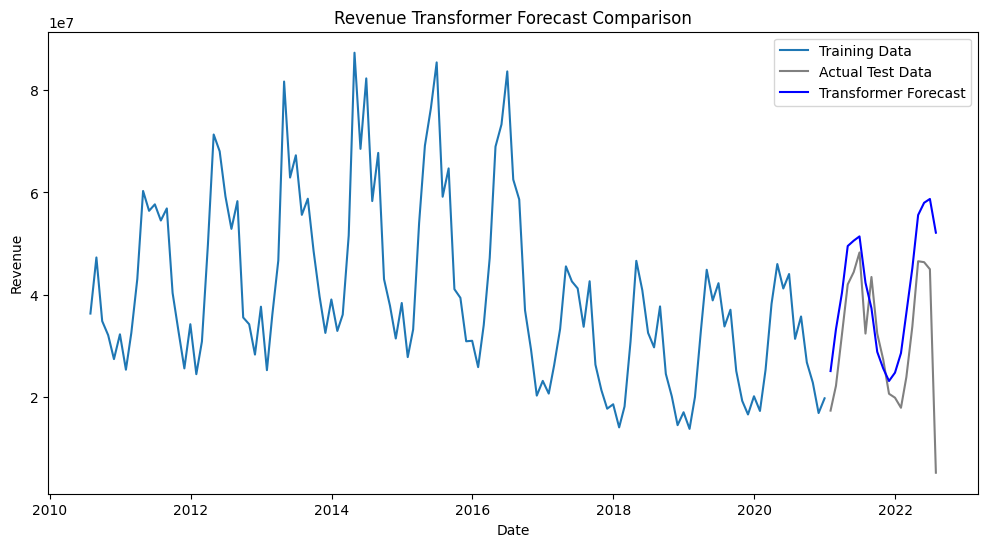

In [42]:
print("\n>>> Revenue Transformer Forecasting")
transformer_predictions_revenue, transformer_metrics_revenue = transformer_forecasting("Revenue", train_revenue,   test_revenue,window_size=12, epochs=100, batch_size=64)


>>> Units Transformer Forecasting

--- Units Transformer Forecasting ---
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 3.8689
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9852 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0444 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1708 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4217 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8500 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5909 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3054 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2253 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2966 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2996 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2461 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1374 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1672 
Epoch 15/100


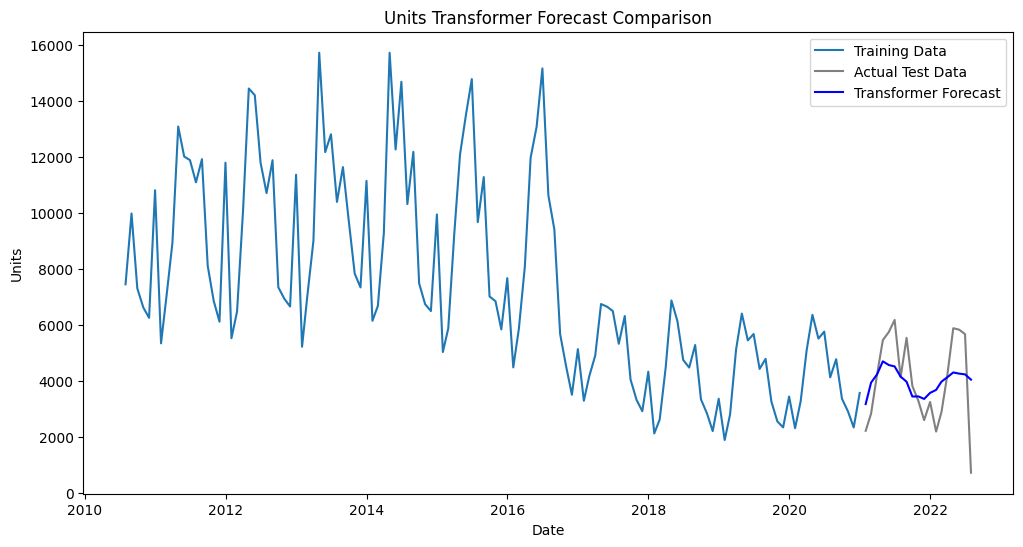

In [56]:
print("\n>>> Units Transformer Forecasting")
transformer_predictions_revenue, transformer_metrics_revenue = transformer_forecasting("Units", train_sales,  test_sales,window_size=12, epochs=100, batch_size=64)


>>> Revenue Transformer Forecasting

--- Revenue Transformer Forecasting ---
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 3.3525
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5.2481
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.2084
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4953
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2029
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.6598
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9983
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4267
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.4179
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6359
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9340
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7168
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4626
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3455
Epoch 15/50
1/1 ━━━━━━━

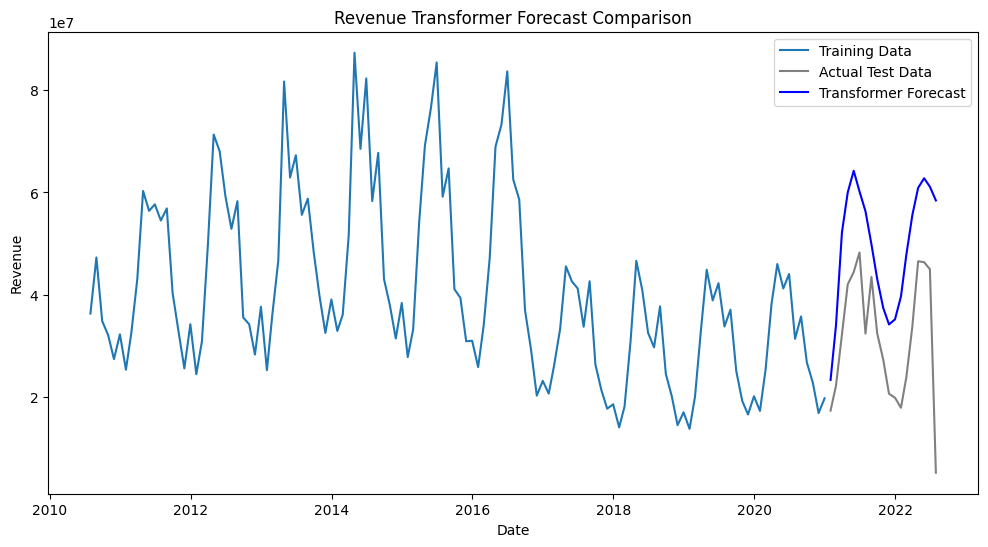

In [ ]:
# train_revenue = monthly_revenue[monthly_revenue.index.year <= 2020]
# test_revenue  = monthly_revenue[monthly_revenue.index.year >= 2021]

print("\n>>> Revenue Transformer Forecasting")
transformer_predictions_revenue, transformer_metrics_revenue = transformer_forecasting("Revenue", train_revenue,   test_revenue,window_size=12, epochs=50, batch_size=128)

## Run for full dataset

### Construct model

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, LayerNormalization, MultiHeadAttention, Embedding, Concatenate, Lambda
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import keras_tuner as kt

In [59]:
numerical_columns = ['Revenue', 'Units']
categorical_columns = ["Category", "Segment", "City", "Region", "District"]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [60]:
agg_dict = {col: 'sum' for col in numerical_columns}
for col in categorical_columns:
    agg_dict[col] = 'first'
monthly_data = df.resample('M').agg(agg_dict)

<ipython-input-60-b4ddd43e8e1c>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M').agg(agg_dict)


In [61]:
train_data = monthly_data[monthly_data.index.year <= 2020]
test_data  = monthly_data[monthly_data.index.year >= 2021]
scaler_num = MinMaxScaler()
train_num = scaler_num.fit_transform(train_data[numerical_columns])
test_num  = scaler_num.transform(test_data[numerical_columns])

train_cat = train_data[categorical_columns].values
test_cat  = test_data[categorical_columns].values

In [62]:
def create_sequences(num_array, cat_array, window_size=12):
    X_num, X_cat, y = [], [], []
    for i in range(len(num_array) - window_size):
        X_num.append(num_array[i:i+window_size])
        X_cat.append(cat_array[i:i+window_size])
        y.append(num_array[i+window_size])  
        
        
    return np.array(X_num), np.array(X_cat), np.array(y)

        
window_size = 12
X_train_num, X_train_cat, y_train = create_sequences(train_num, train_cat, window_size)
X_test_num, X_test_cat, y_test    = create_sequences(test_num, test_cat, window_size)


In [63]:
def build_multivariate_transformer_model(hp):
    embedding_dim = hp.Choice('embedding_dim', values=[8, 16, 32], default=16) 
    projection_dim = hp.Choice('projection_dim', values=[32, 64, 128], default=64)
    num_heads = hp.Choice('num_heads', values=[1, 2, 4], default=2)
    ff_dim = hp.Choice('ff_dim', values=[32, 64, 128], default=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.2)
    num_transformer_blocks = hp.Int('num_transformer_blocks', min_value=1, max_value=3, default=1)
    dense_units = hp.Choice('dense_units', values=[32, 64, 128], default=64)
    
    num_features = len(numerical_columns)
    cat_features = len(categorical_columns)
    
    input_num = Input(shape=(window_size, num_features), name='num_input')
    input_cat = Input(shape=(window_size, cat_features), name='cat_input')
    
    embedded_list = []
    for i in range(cat_features):
        x = Lambda(lambda t: t[:, :, i])(input_cat)  
        num_unique = int(np.max(train_cat[:, i]) + 1)
        emb = Embedding(input_dim=num_unique + 1, output_dim=embedding_dim, input_length=window_size)(x)
        embedded_list.append(emb)
    
    cat_embeddings = Concatenate(axis=-1)(embedded_list)  
    x = Concatenate(axis=-1)([input_num, cat_embeddings])
    
    x = Dense(projection_dim)(x)
    
    for _ in range(num_transformer_blocks):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x, x) # check for dim in self-attention
        attn_output = Dropout(dropout_rate)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        ffn_output = Dense(ff_dim, activation='relu')(x)
        ffn_output = Dense(projection_dim)(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(x + ffn_output)
    
    x = Flatten()(x)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(num_features)(x)
    
    model = Model(inputs=[input_num, input_cat], outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model



In [ ]:
## COPY AND PASTE

tuner = kt.RandomSearch(
    build_multivariate_transformer_model,
    objective='val_loss',
    max_trials=10,       
    executions_per_trial=1,
    directory='multivariate_transformer_tuning',
    project_name='multivariate_transformer_forecasting'
)

tuner.search_space_summary()


tuner.search([X_train_num, X_train_cat], y_train, epochs=50, validation_split=0.2, verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Optimal hyperparameters:")
print(f"embedding_dim: {best_hps.get('embedding_dim')}")
print(f"projection_dim: {best_hps.get('projection_dim')}")
print(f"num_heads: {best_hps.get('num_heads')}")
print(f"ff_dim: {best_hps.get('ff_dim')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"num_transformer_blocks: {best_hps.get('num_transformer_blocks')}")
print(f"dense_units: {best_hps.get('dense_units')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit([X_train_num, X_train_cat], y_train, epochs=50, validation_split=0.2)


Trial 10 Complete [00h 00m 30s]
val_loss: 0.009925887919962406

Best val_loss So Far: 0.008155127987265587
Total elapsed time: 00h 03m 34s
Optimal hyperparameters:
embedding_dim: 8
projection_dim: 32
num_heads: 4
ff_dim: 128
dropout_rate: 0.4
num_transformer_blocks: 1
dense_units: 32
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.7797 - val_loss: 0.7065
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4271 - val_loss: 0.5930
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4492 - val_loss: 0.2717
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2631 - val_loss: 0.1636
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2267 - val_loss: 0.1313
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1263 - val_loss: 0.0827
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1033 - val_loss: 0.0480
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1082 - val_loss: 0.0322
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - l

### Run final model

RERUN AGAIN :)

In [64]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.4):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def call(self, inputs, training=False):  
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [28]:
df.head()

,Unnamed: 0,ProductID,Zip,Units,Revenue,COGS,Category,Segment,Product,City,State,Region,District
Date,,,,,,,,,,,,,
2010-07-04,26731,604,47946,1,5767.65,3893.740515,2,1,Maximus UC-69,7715,IN,1,16
2010-07-04,293369,1859,20008,1,1877.40,1545.287940,3,7,Pomum YY-54,22670,DC,1,6
2010-07-04,301201,485,44830,1,10218.60,10973.754540,2,3,Maximus UM-90,7676,OH,1,13
2010-07-04,301203,485,55008,1,10218.60,10973.754540,2,3,Maximus UM-90,3110,MN,0,27
2010-07-04,301207,485,47380,1,10218.60,10973.754540,2,3,Maximus UM-90,18270,IN,1,15


In [65]:
categorical_columns = ["Category", "Segment", "City", "Region", "District"]
numerical_columns = ["Revenue", "Units"]

label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [66]:
agg_dict = {col: 'sum' for col in numerical_columns}
for col in categorical_columns:
    agg_dict[col] = 'first' 
monthly_data = df.resample('M').agg(agg_dict)

train_data = monthly_data[monthly_data.index.year <= 2020]
test_data  = monthly_data[monthly_data.index.year >= 2021]

scaler_num = MinMaxScaler()
train_num = scaler_num.fit_transform(train_data[numerical_columns])
test_num = scaler_num.transform(test_data[numerical_columns])

# train_cat = train_data[numerical_columns].values
train_cat = train_data[categorical_columns].values
test_cat = test_data[categorical_columns].values


<ipython-input-66-c94efa658da7>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M').agg(agg_dict)


In [67]:
def create_sequences(num_array, cat_array, target, window_size=12):
    X_num, X_cat, y = [], [], []
    for i in range(len(num_array) - window_size):
        X_num.append(num_array[i:i+window_size])
        X_cat.append(cat_array[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X_num), np.array(X_cat), np.array(y)

train_target = train_num  
test_target = test_num

window_size = 12
X_train_num, X_train_cat, y_train = create_sequences(train_num, train_cat, train_target, window_size)
X_test_num, X_test_cat, y_test = create_sequences(test_num, test_cat, test_target, window_size)

num_numerical_features = X_train_num.shape[-1]      
num_categorical_features = len(categorical_columns)   
cat_cardinalities = [df[col].nunique() for col in categorical_columns]


In [68]:



embedding_dim = 8      
projection_dim = 32
ff_dim = 128
num_heads = 4
output_dim = len(numerical_columns)  

def build_transformer_with_embeddings(window_size, num_numerical_features, num_categorical_features,cat_cardinalities, embedding_dim=embedding_dim, projection_dim=projection_dim, ff_dim=ff_dim, num_heads=num_heads, output_dim=2):
    input_num = Input(shape=(window_size, num_numerical_features), name="num_input")
    input_cat = Input(shape=(window_size, num_categorical_features), name="cat_input")
    
    embedded_list = []
    for i in range(num_categorical_features):
        x = Lambda(lambda t: t[:,:,i])(input_cat)  
        emb = Embedding(input_dim=cat_cardinalities[i] + 1, output_dim=embedding_dim, input_length=window_size)(x) 
        embedded_list.append(emb)
    cat_embeddings = Concatenate(axis=-1)(embedded_list)
    
    x = Concatenate(axis=-1)([input_num, cat_embeddings])
    x = Dense(projection_dim)(x)
    
    transformer_block = TransformerBlock(projection_dim, num_heads, ff_dim)
    x = transformer_block(x)
    
    # x = Flatten()(x)[1:]
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(output_dim)(x)
    
    model = Model(inputs=[input_num, input_cat], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
model = build_transformer_with_embeddings(window_size, num_numerical_features, num_categorical_features, cat_cardinalities, embedding_dim, projection_dim, ff_dim, num_heads, output_dim)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cat_input (InputLayer)    │ (None, 12, 5)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_10 (Lambda)        │ (None, 12)             │              0 │ cat_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_11 (Lambda)        │ (None, 12)             │              0 │ cat_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_12 (Lambda)        │ (None, 12)             │              0 │ cat_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_13 (Lambda)        │ (None, 12)             │              0 │ cat_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_14 (Lambda)        │ (None, 12)             │              0 │ cat_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_10 (Embedding)  │ (None, 12, 8)          │             40 │ lambda_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_11 (Embedding)  │ (None, 12, 8)          │             72 │ lambda_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_12 (Embedding)  │ (None, 12, 8)          │        192,832 │ lambda_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_13 (Embedding)  │ (None, 12, 8)          │             32 │ lambda_13[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_14 (Embedding)  │ (None, 12, 8)          │            320 │ lambda_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ num_input (InputLayer)    │ (None, 12, 2)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 12, 40)         │              0 │ embedding_10[0][0],    │
│ (Concatenate)             │                        │                │ embedding_11[0][0],    │
│                           │                        │                │ embedding_12[0][0],    │
│                           │                        │                │ embedding_13[0][0],    │
│                           │                        │                │ embedding_14[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 12, 42)         │              0 │ num_input[0][0],       │
│ (Concatenate)             │                        │                │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 12, 32)         │          1,376 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block         │ (None, 12, 32)         │         25,280 │ dense_14[0][0]         │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)  

 Total params: 244,722 (955.95 KB)

 Trainable params: 244,722 (955.95 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - loss: 1.1228
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6795 
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3179 
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2645 
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2131 
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1938 
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1380 
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1107 
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1250 
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1383 
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0887 
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1033 
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0885 
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0797 
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0794 
Epoch 16/100
2/2 ━━━

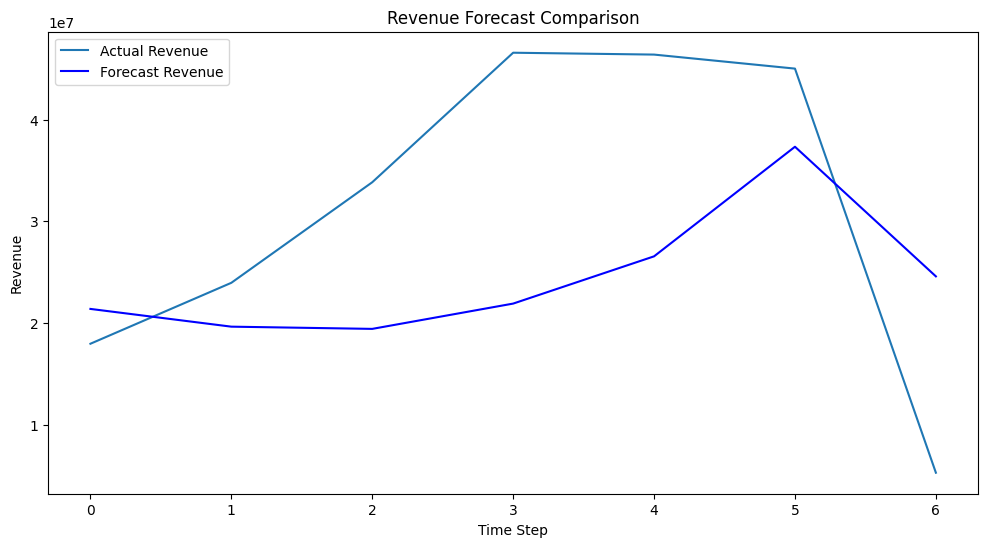

In [70]:
history = model.fit([X_train_num, X_train_cat], y_train, epochs=100, batch_size=64, verbose=1)
predictions_scaled = model.predict([X_test_num, X_test_cat])
predictions = scaler_num.inverse_transform(predictions_scaled)
actual = scaler_num.inverse_transform(y_test)



rmse, mape,r2 = compute_metrics(actual, predictions)
print(f"Forecasting: RMSE = {rmse:.2f}, MAPE = {mape:.2f}%, R²={r2:.2f}")




plt.figure(figsize=(12,6))
plt.plot(range(len(actual)), actual[:,0], label="Actual Revenue")
plt.plot(range(len(predictions)), predictions[:,0], label="Forecast Revenue", color='blue')
plt.title("Revenue Forecast Comparison")
plt.xlabel("Time Step")
plt.ylabel("Revenue")
plt.legend()
plt.show()

Units Forecasting: RMSE = 1558.94, MAPE = 80.46%, R²=0.32


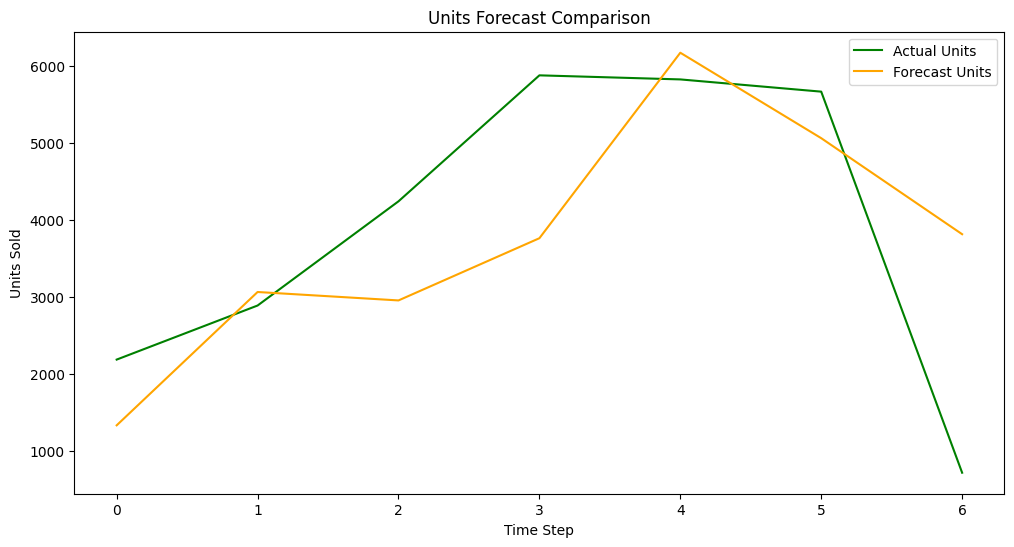

In [72]:
rmse_units, mape_units, r2_units = compute_metrics(actual[:, 1], predictions[:, 1])
print(f"Units Forecasting: RMSE = {rmse_units:.2f}, MAPE = {mape_units:.2f}%, R²={r2_units:.2f}")
plt.figure(figsize=(12,6))
plt.plot(range(len(actual)), actual[:,1], label="Actual Units", color='green')
plt.plot(range(len(predictions)), predictions[:,1], label="Forecast Units", color='orange')
plt.title("Units Forecast Comparison")
plt.xlabel("Time Step")
plt.ylabel("Units Sold")
plt.legend()
plt.show()